# Heart Disease Prediction

## Introduction
Our data was collected by the Hungarian Institute of Cardiology in Budapest on Heart Disease patients.
Heart disease can refer to several types of heart conditions, the most common being the buildup of plaque in the major blood vessels leading to the heart. Cholesterol deposits in the arteries reduce blood flow to the heart. 
Our project aims to determine if someone has heart disease, based on some of the predictors in the dataset.
We will be using the Heart Disease data folder. Specifically,  we are using the Processed Hungarian Data, which is a data set in the Heart Disease folder.

## Methods and Results
In the code below, we read the data from the url, clean and wrangle it, split it into training and testing sets, compute summary statistics on the training data, standardize the training data. We also plot multiple sets of 2 of the standardized predictors (e.g. age and max heart rate) onto a scatter plot and colour the points based on whether the individual has heart disease to discuss and justify why we chose the predictors that we did for our analysis. Then we perform knn classification by first running cross validation to find a number of neighbours for which our accuracy estimate is high and then use our model to predict on our testing data, determine the testing accuracy, and plot a confusion matrix. Our process and code are justified and explained further below and in the discussion as well.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

We will start by setting the seed and reading the data from the url. We will also add some column names since the dataset itself does not include them.

In [2]:
# Set seed
set.seed(1000)

# Read data
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data"
heart_disease_data <- read_csv(url, col_names = FALSE)

# Add column names
heart_disease_data <- rename(heart_disease_data,
       age = X1, 
       sex = X2, 
       chest_pain_type = X3,
       resting_blood_pressure = X4, 
       cholestorol = X5, 
       fasting_blood_sugar = X6,
       restecg = X7, 
       max_heart_rate = X8, 
       exercise_induced_angina = X9,
       ST_depression = X10, 
       slope = X11, 
       ca = X12,
       thal = X13, 
       has_heart_disease = X14)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Next, we remove columns from the data that will not be used in our analysis and filter out observations that have missing data (data with '?' character). We removed the slope, ca, and thal columns from our dataframe because for these columns most of the data is missing. For the remaining columns, for which the missing data is sparse, we removed observations with missing data because our classifier would not work correctly if some observations had missing data for the predictors. Since this missing data is present only sparsely and our dataset is quite large, removing the observations with missing data will not affect our model very much. The resulting data frame is shown in Table 1 below.

In [3]:
# Remove unnecessary columns (these won't be used in our analysis)
heart_disease_data <- heart_disease_data |>
   select(-slope, -ca, -thal)

# Filter out observations with missing data
heart_disease_data <- heart_disease_data |>
   filter(resting_blood_pressure != '?', cholestorol != '?', fasting_blood_sugar != '?', restecg != '?', max_heart_rate != '?', exercise_induced_angina != '?', ST_depression != '?')
heart_disease_data

age,sex,chest_pain_type,resting_blood_pressure,cholestorol,fasting_blood_sugar,restecg,max_heart_rate,exercise_induced_angina,ST_depression,has_heart_disease
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
28,1,2,130,132,0,2,185,0,0,0
29,1,2,120,243,0,0,160,0,0,0
30,0,1,170,237,0,1,170,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,1
58,0,2,180,393,0,0,110,1,1,1
65,1,4,130,275,0,1,115,1,1,1


Table 1: Heart Disease Data Frame After Removing Unncessary Columns and Observations with Missing Data

Now we convert the columns in our data to numeric type so that they are easier to analyze and work with. We also convert the heart disease labels from numbers (1 and 0) to words (Yes and No) for easier interprebility when reading the data.

In [4]:
# Convert columns to numeric type
heart_disease_data$resting_blood_pressure <- as.numeric(heart_disease_data$resting_blood_pressure)
heart_disease_data$cholestorol <- as.numeric(heart_disease_data$cholestorol)
heart_disease_data$fasting_blood_sugar <- as.numeric(heart_disease_data$fasting_blood_sugar)
heart_disease_data$restecg <- as.numeric(heart_disease_data$restecg)
heart_disease_data$max_heart_rate <- as.numeric(heart_disease_data$max_heart_rate)
heart_disease_data$exercise_induced_angina <- as.numeric(heart_disease_data$exercise_induced_angina)
heart_disease_data$ST_depression <- as.numeric(heart_disease_data$ST_depression)
heart_disease_data$has_heart_disease <- as.factor(heart_disease_data$has_heart_disease)

# Convert heart disease labels from numbers to words
levels(heart_disease_data$has_heart_disease)[levels(heart_disease_data$has_heart_disease) == '0'] <- 'No'
levels(heart_disease_data$has_heart_disease)[levels(heart_disease_data$has_heart_disease) == '1'] <- 'Yes'

Now, we begin our analysis by splitting the data into training and testing sets. We chose a 75% to 25% split of training to testing sets. The training set we will use is shown in Table 2 below.

In [5]:
# Split the data into training and testing sets
heart_disease_data_split <- initial_split(heart_disease_data, prop = 0.75, strata = has_heart_disease)
heart_disease_data_training <- training(heart_disease_data_split)
heart_disease_data_testing <- testing(heart_disease_data_split)

# Print training data
heart_disease_data_training

age,sex,chest_pain_type,resting_blood_pressure,cholestorol,fasting_blood_sugar,restecg,max_heart_rate,exercise_induced_angina,ST_depression,has_heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,1,2,130,132,0,2,185,0,0,No
30,0,1,170,237,0,1,170,0,0,No
32,0,2,105,198,0,0,165,0,0,No
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
54,0,3,130,294,0,1,100,1,0,Yes
56,1,4,155,342,1,0,150,1,3,Yes
65,1,4,130,275,0,1,115,1,1,Yes


Table 2: Heart Disease Training Data

Next, we compute some summary statistics on our data. The summary statistics (shown in Table 3 below) were computed by grouping the rows based on whether the individual has heart disease and then computing the means of the relevant predictors. We don't include the sex, chest pain type, resting electrocardiographic results, and exercise induced angina columns since these columns are discrete where each discrete value maps to a distinct result so a mean would not provide any helpful information.

In [6]:
# Summarize the training data by grouping by num and calculating means of the various columns
summary <- heart_disease_data_training |>
   group_by(has_heart_disease) |>
   summarize(across(age:ST_depression, mean))

# Remove columns for which mean is not useful (i.e. data is discrete and not continuous)
summary <- summary |>
   select(-sex, -chest_pain_type, -restecg, -exercise_induced_angina)

# Print summary statistics
summary

has_heart_disease,age,resting_blood_pressure,cholestorol,fasting_blood_sugar,max_heart_rate,ST_depression
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
No,46.94262,131.6148,240.2705,0.04098361,147.5492,0.2172131
Yes,49.49315,135.2877,265.8356,0.13698630,128.5068,1.2876712


Table 3: Heart Disease Data Summary Statistics

These summary statistics show useful information about our dataset. We see that the average age, resting blood pressure, cholestorol, fasting blood sugar, maximum heart rate, and ST depression induced by exercise for individuals with heart disease is higher than individuals without heart disease.

We scale the data so that we can perform knn classification on it.

In [7]:
# Select data to visualize
heart_disease_training_plot_data <- heart_disease_data_training

# Scale data for effective visualization
heart_disease_recipe <- recipe(has_heart_disease ~ ., data = heart_disease_training_plot_data) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

Now we perform 5-fold cross validation to find a suitable value of k for our knn classification. We plot our accuracy versus k, as shown in Figure 1 below, to see that value of k for which we have the highest training accuracy.

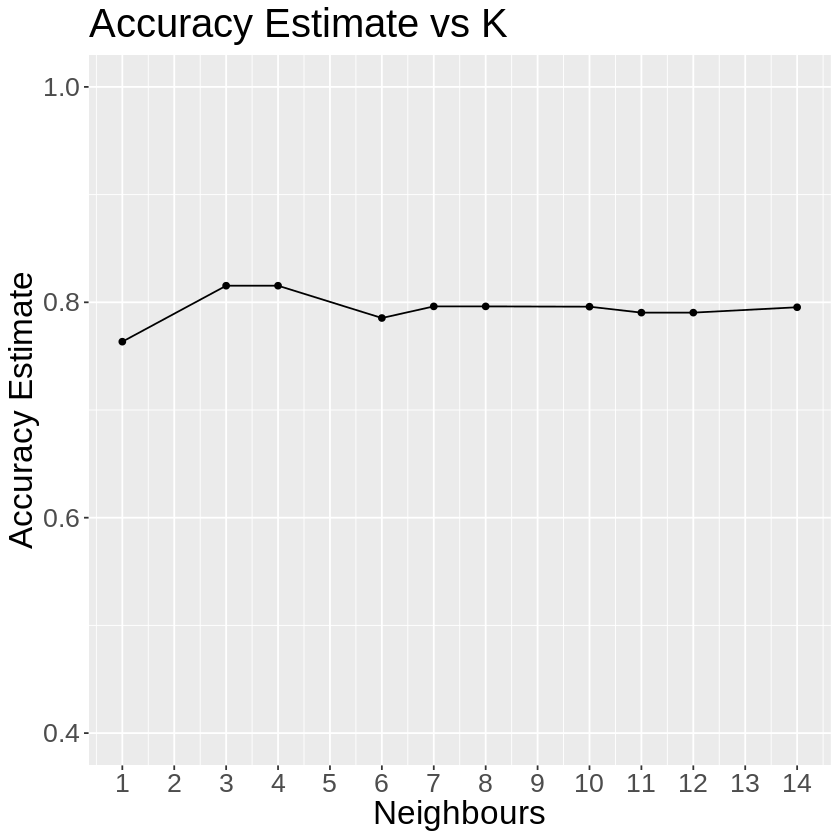

In [8]:
# Cross Validation
heart_vfold <- vfold_cv(heart_disease_training_plot_data, v = 5, strata = has_heart_disease)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

knn_results <- workflow() |>
      add_recipe(heart_disease_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = heart_vfold, grid = 10) |>
      collect_metrics()

accuracies <- knn_results |> 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      xlab("Neighbours") +
      ylab("Accuracy Estimate") +
      ggtitle("Accuracy Estimate vs K") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +
      scale_y_continuous(limits = c(0.4, 1.0)) +
      theme(text = element_text(size = 20))
accuracy_versus_k

Figure 1: Accuracy Estimate vs K

We see from the plot that the K value with the highest training accuracy is k = 3 so we select this as our value. We create our model specification with k = 3 and combine it with our recipe from before into a workflow and build our classifier.

In [9]:
# Set seed
set.seed(1000)

knn_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
      set_engine("kknn") |>
      set_mode("classification")

heart_fit <- workflow() |>
      add_recipe(heart_disease_recipe) |>
      add_model(knn_model) |>
      fit(data = heart_disease_training_plot_data)

Now, we test our classifier by making predictions for the data in our testing set. The data with predictions is shown in Table 4 below.

In [10]:
# Set seed
set.seed(1000)

heart_test_predictions <- predict(heart_fit , heart_disease_data_testing) |>
      bind_cols(heart_disease_data_testing)
heart_test_predictions

.pred_class,age,sex,chest_pain_type,resting_blood_pressure,cholestorol,fasting_blood_sugar,restecg,max_heart_rate,exercise_induced_angina,ST_depression,has_heart_disease
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
No,29,1,2,120,243,0,0,160,0,0,No
No,31,0,2,100,219,0,1,150,0,0,No
No,32,1,2,110,225,0,0,184,0,0,No
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Yes,47,1,4,160,291,0,1,158,1,3,Yes
Yes,52,1,4,140,266,0,0,134,1,2,Yes
Yes,58,0,2,180,393,0,0,110,1,1,Yes


Table 4: Heart Disease Data with Predictions

The prediction accuracy, as shown in Table 5 below, is about 81.8% which is relatively good.

In [11]:
heart_prediction_accuracy <- heart_test_predictions |>
        metrics(truth = has_heart_disease, estimate = .pred_class)
heart_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8181818
kap,binary,0.6195965


Table 5: Heart Disease Prediction Metrics from Test Data

We have included 3 visualizations (as shown in Figures 2, 3, and 4 below) for exploratory data analysis relating to our analysis. They are scatter plots with 2 predictors (one on each axis) and coloured by heart disease. These plots are discussed in further detail in our discussion.

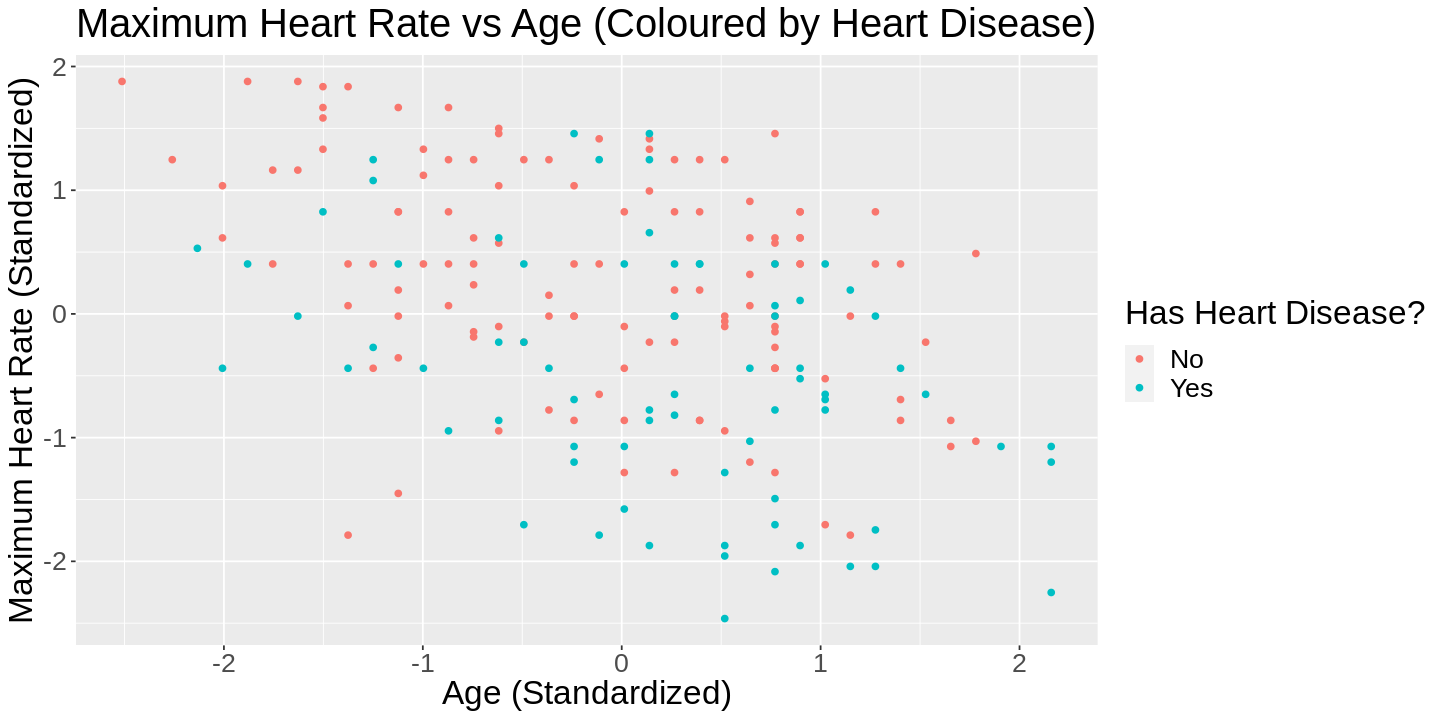

In [12]:
# Set seed
set.seed(1000)

heart_disease_recipe <- heart_disease_recipe |>
   prep()
scaled_heart_disease_data <- bake(heart_disease_recipe, heart_disease_training_plot_data)

# Change plot dimensions
options(repr.plot.width = 12, repr.plot.height = 6)

# Plot data
heart_disease_plot_1 <- scaled_heart_disease_data |>
   ggplot(aes(x = age, y = max_heart_rate, color = has_heart_disease)) +
   geom_point() +
   theme(text = element_text(size = 20)) +
   labs(x = "Age (Standardized)", y = "Maximum Heart Rate (Standardized)", title = "Maximum Heart Rate vs Age (Coloured by Heart Disease)", color = "Has Heart Disease?")

heart_disease_plot_2 <- scaled_heart_disease_data |>
   ggplot(aes(x = age, y = cholestorol, color = has_heart_disease)) +
   geom_point() +
   theme(text = element_text(size = 20)) +
   labs(x = "Age (Standardized)", y = "Cholestorol (Standardized)", title = "Cholestorol vs Age (Coloured by Heart Disease)", color = "Has Heart Disease?")

heart_disease_plot_3 <- scaled_heart_disease_data |>
   ggplot(aes(x = resting_blood_pressure, y = max_heart_rate, color = has_heart_disease)) +
   geom_point() +
   theme(text = element_text(size = 20)) +
   labs(x = "Resting Blood Pressure (Standardized)", y = "Maximum Heart Rate (Standardized)", title = "Maximum Heart Rate vs Resting Blood Prssure (Coloured by Heart Disease)", color = "Has Heart Disease?")

# Display plot
heart_disease_plot_1

Figure 2: Maximum Heart Rate vs Age (Coloured by Heart Disease)

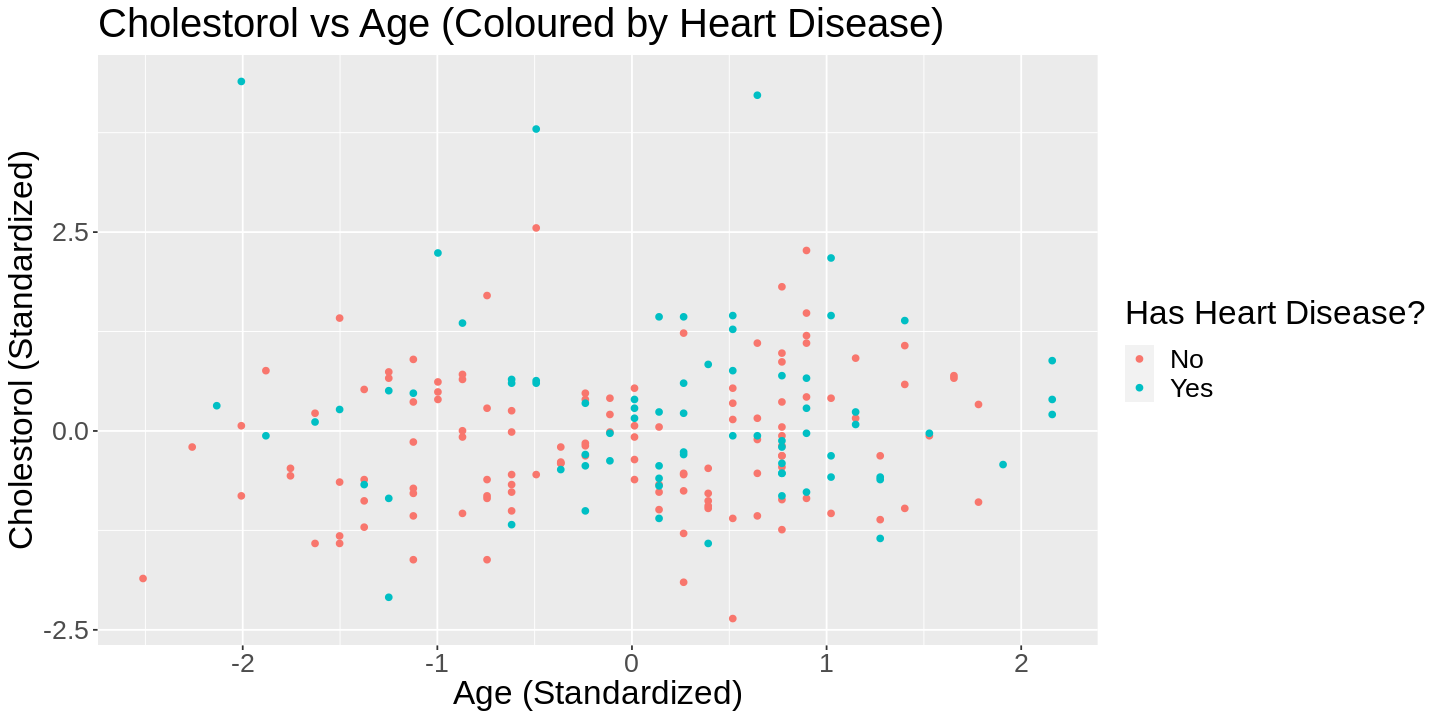

In [13]:
# Display Plot
heart_disease_plot_2

Figure 3: Cholestorol vs Age (Coloured by Heart Disease)

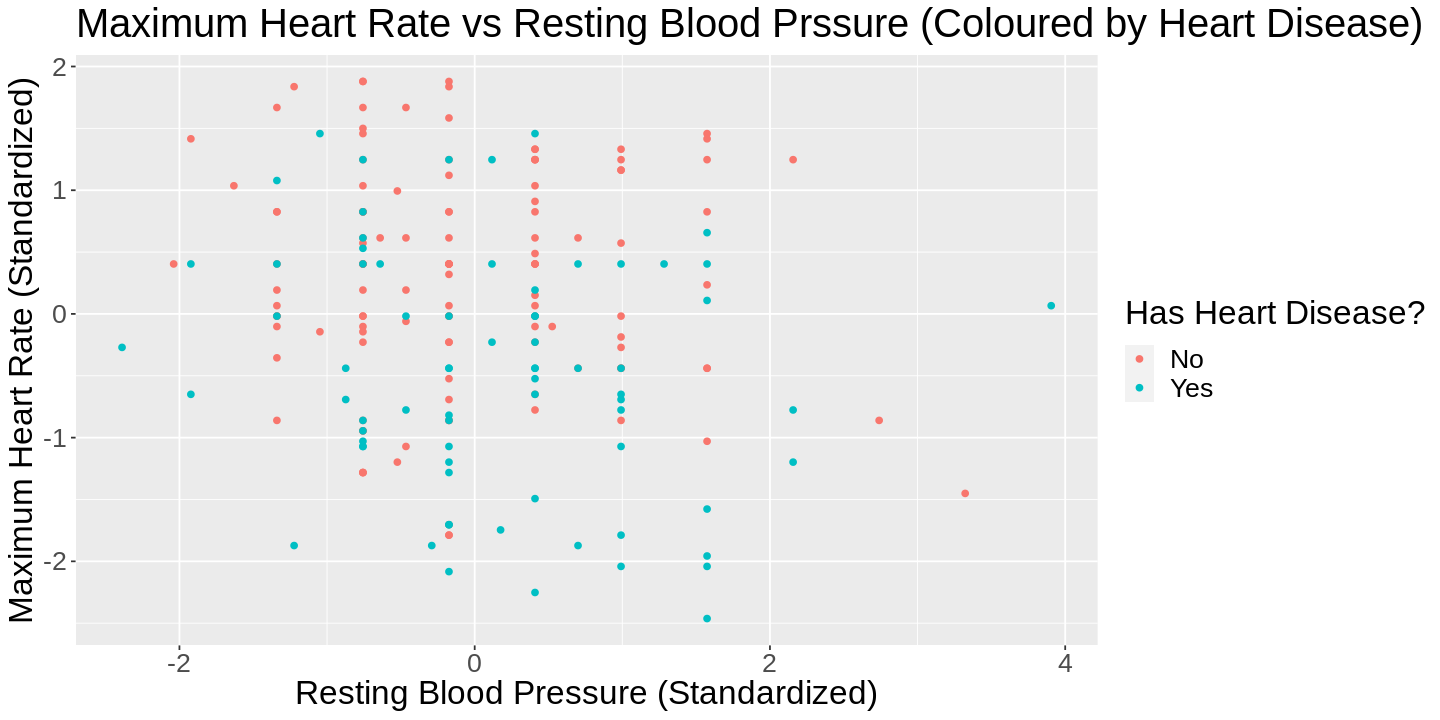

In [14]:
# Display Plot
heart_disease_plot_3

Figure 4: Maximum Heart Rate vs Resting Blood Pressure (Coloured by Heart Disease)

For the visualization of our analysis we have included a plot of a confusion matrix, as shown in Figure 5 below. This confusion matrix visualized the performance of our classifer and how well it was at predicting on our testing set. This visualization is further discussed in our discussion.

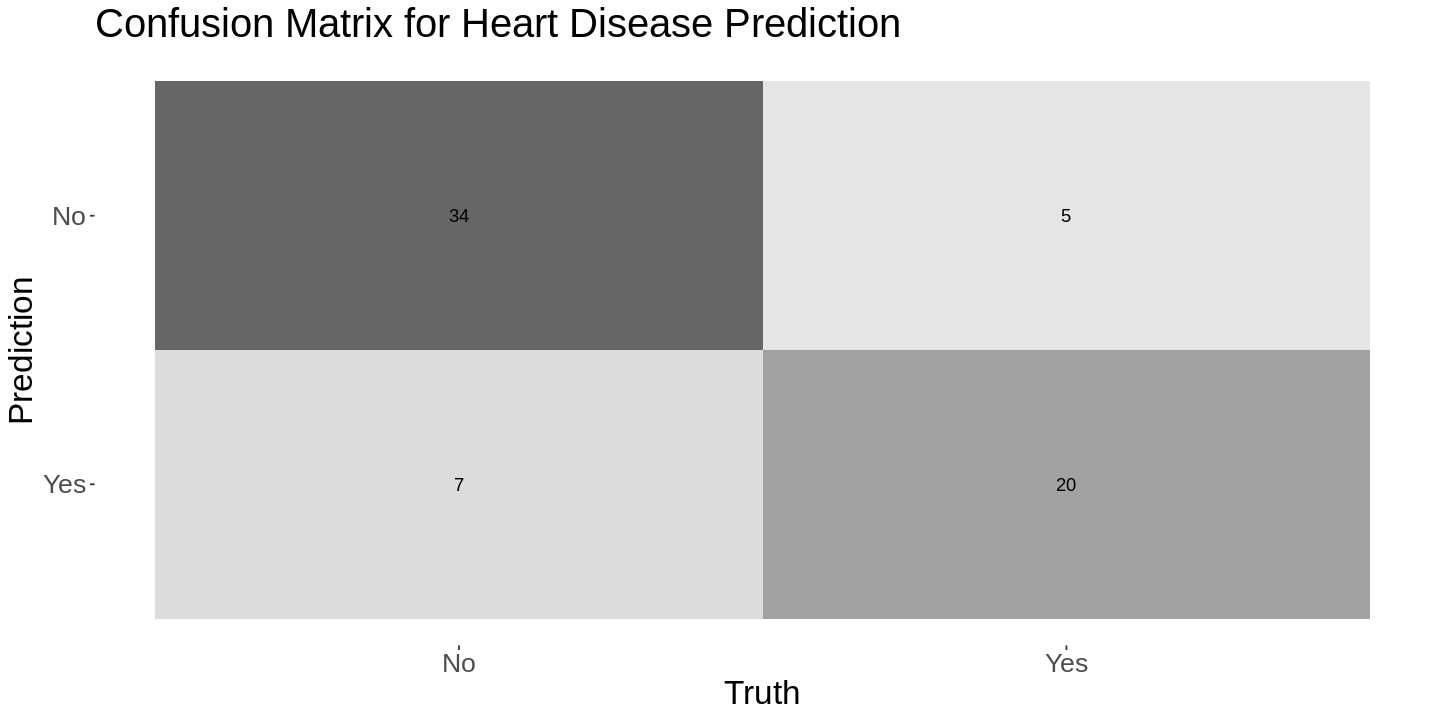

In [15]:
# Create confusion matrix
conf_matrix <- heart_test_predictions |>
             conf_mat(truth = has_heart_disease, estimate = .pred_class)

# Confusion matrix visualization
conf_matrix_plot <- autoplot(conf_matrix, type = "heatmap") +
   ggtitle("Confusion Matrix for Heart Disease Prediction") +
   theme(text = element_text(size = 20))
conf_matrix_plot

Figure 5: Confusion Matrix Plot for Heart Disease Prediction on Testing Set

# Expected Outcomes and Significance

These findings could potentially show new relationships between factors that are known to be related to heart disease. This is impactful, because heart disease is a very common cause of death everywhere. It is important for data scientists in the healthcare industry to uncover as much information about heart disease.

A question this could lead to is whether or not our findings could be applied by heart doctors to help them predict heart disease more accurately.
Another question is whether or not certain predictors have more correlation to heart disease than others.